<h2 align=center> Named Entity Recognition (NER) using LSTMs with Keras</h2>

### Task 1: Project Overview and Import Modules

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf

### Task 2: Load and Explore the NER Dataset

*Essential info about tagged entities*:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

In [2]:
#Loading data
data= pd.read_csv("https://raw.githubusercontent.com/yrnigam/Named-Entity-Recognition-NER-using-LSTMs/master/ner_dataset.csv",encoding="latin1")

In [3]:
#Looking for null values
print(data.isnull().sum())

Sentence #    1000616
Word                0
POS                 0
Tag                 0
dtype: int64


In [4]:
#Filling Null Values
data = data.fillna(method='ffill')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [5]:
print("Unique Words in corpus:",data['Word'].nunique())
print("Unique Tag in corpus:",data['Tag'].nunique())

Unique Words in corpus: 35178
Unique Tag in corpus: 17


In [6]:
print(data['Tag'].unique())

['O' 'B-geo' 'B-gpe' 'B-per' 'I-geo' 'B-org' 'I-org' 'B-tim' 'B-art'
 'I-art' 'I-per' 'I-gpe' 'I-tim' 'B-nat' 'B-eve' 'I-eve' 'I-nat']


In [7]:
#Storing unique words and tags as a list
words = list(set(data['Word'].values))
words.append("ENDPAD")
num_words = len(words)

In [8]:
tags = list(set(data['Tag'].values))
num_tags = len(tags)

In [9]:
num_words, num_tags

(35179, 17)

### Task 3: Retrieve Sentences and Corresponsing Tags

In [10]:
#Creating a class to get data in desired formate. i.e. Word,POS,Tag
class SentanceGetter(object):
    def __init__(self,data):
        self.n_sent = 1 #counter
        self.data = data
        agg_func = lambda s:[(w,p,t) for w,p,t in zip(s['Word'].tolist(),s['POS'].tolist(),s['Tag'].tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentances = [s for s in self.grouped]

In [11]:
getter = SentanceGetter(data)
sentances = getter.sentances

In [12]:
sentances[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

### Task 4: Define Mappings between Sentences and Tags

In [13]:
word2idx =  {w : i+1 for i,w in enumerate(words)}
tag2idx  =  {t : i for i,t in enumerate(tags)}

In [14]:
word2idx

{'body': 1,
 'Kidwa': 2,
 'Annunciation': 3,
 'prodemocracy': 4,
 'wont': 5,
 'inventory': 6,
 'all-star': 7,
 'Taliban-allied': 8,
 'Bueno': 9,
 'dramatizes': 10,
 'building': 11,
 'kits': 12,
 'Johnston': 13,
 'Ringwald': 14,
 'Nuevo': 15,
 'tiger': 16,
 'expecting': 17,
 'fibroids': 18,
 'rebuked': 19,
 're-established': 20,
 'SHEPHERD': 21,
 'Alonso': 22,
 'buster': 23,
 'extremist': 24,
 '330': 25,
 'Moradi': 26,
 'Cent': 27,
 'illustrious': 28,
 '1979': 29,
 'four-day': 30,
 'Way': 31,
 'skip': 32,
 'sensual': 33,
 '2,698': 34,
 'al-Hudaidah': 35,
 'Yokota': 36,
 'minister-designate': 37,
 'anytime': 38,
 '54.95': 39,
 'busiest': 40,
 'reaffirm': 41,
 'Combined': 42,
 'Magomedtagirov': 43,
 'sharply': 44,
 'ceramic': 45,
 'savage': 46,
 'managing': 47,
 'Venezuelans': 48,
 'anti-Ethiopian': 49,
 'taboo': 50,
 'Awori': 51,
 'lobbed': 52,
 'deliverer': 53,
 'tear': 54,
 '1657': 55,
 'oppress': 56,
 'Fazul': 57,
 'provinces': 58,
 'Araujo': 59,
 'exchange': 60,
 'interfere': 61,
 'S

### Task 5: Padding Input Sentences and Creating Train/Test Splits


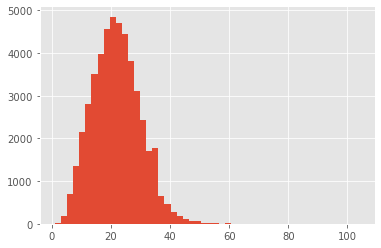

In [15]:
plt.hist([len(s) for s in sentances], bins=50)
plt.show()

In [16]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_len = 50

X = [[word2idx[w[0]] for w in s]for s in sentances]
X = pad_sequences(maxlen = max_len , sequences =X, padding='post', value =num_words-1)

y = [[tag2idx[w[2]] for w in s]for s in sentances]
y = pad_sequences(maxlen = max_len , sequences =y, padding='post', value =tag2idx["O"])
y = [to_categorical(i, num_classes=num_tags) for i in y]

In [17]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,y, test_size=0.1, random_state=1)

### Task 6: Build and Compile a Bidirectional LSTM Model

In [18]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [19]:
input_word = Input(shape = (max_len,))
model = Embedding(input_dim=num_words,output_dim=max_len,input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags,activation='softmax'))(model)
model = Model(input_word,out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            1758950   
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 50)           0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 50, 200)          120800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 50, 17)           3417      
 ibuted)                                                         
                                                             

In [20]:
model.compile(optimizer="adam",loss='categorical_crossentropy',metrics=['accuracy'])

### Task 7: Train the Model

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

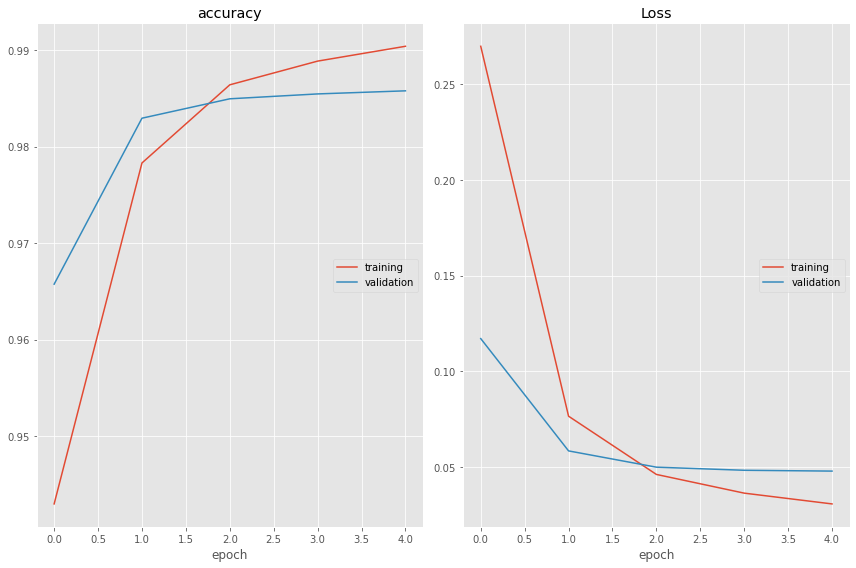

accuracy
	training         	 (min:    0.943, max:    0.990, cur:    0.990)
	validation       	 (min:    0.966, max:    0.986, cur:    0.986)
Loss
	training         	 (min:    0.031, max:    0.270, cur:    0.031)
	validation       	 (min:    0.048, max:    0.117, cur:    0.048)
540/540 [==============================] - 73s 136ms/step - loss: 0.0309 - accuracy: 0.9904 - val_loss: 0.0480 - val_accuracy: 0.9858


In [22]:
early_stopping = EarlyStopping(monitor='val_accuracy',patience=1,verbose=0,mode='max',restore_best_weights=False)
callbacks = [PlotLossesCallback(),early_stopping]

history = model.fit(
    x_train,np.array(y_train),
    validation_split = 0.2,
    batch_size = 64,
    epochs = 5,
    verbose = 1,
    callbacks=callbacks
)

### Task 8: Evaluate Named Entity Recognition Model

In [23]:
model.evaluate(x_test, np.array(y_test))

150/150 [==============================] - 2s 13ms/step - loss: 0.0501 - accuracy: 0.9855


[0.05007897689938545, 0.9854754209518433]

In [25]:
i = 10
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)

y_true = np.argmax(np.array(y_test), axis=-1)[i]
print("{:15}{:5}\t {}\n".format("Word","True","Pred"))
print("-"*30)
for w,true,pred in zip(x_test[i], y_true, p[0]):
  print("{:15}{:5}\t{}".format(words[w-1], tags[true],tags[pred]))

Word           True 	 Pred

------------------------------
After          O    	O
dropping       O    	O
the            O    	O
opener         O    	O
to             O    	O
Slovakia       B-geo	B-geo
,              O    	O
05-Mar         O    	O
,              O    	O
Russia         B-geo	B-geo
has            O    	O
won            O    	O
three          O    	O
straight       O    	O
games          O    	O
by             O    	O
a              O    	O
combined       O    	O
score          O    	O
of             O    	O
15-Feb         O    	O
.              O    	O
Yuganskneftgaz O    	O
Yuganskneftgaz O    	O
Yuganskneftgaz O    	O
Yuganskneftgaz O    	O
Yuganskneftgaz O    	O
Yuganskneftgaz O    	O
Yuganskneftgaz O    	O
Yuganskneftgaz O    	O
Yuganskneftgaz O    	O
Yuganskneftgaz O    	O
Yuganskneftgaz O    	O
Yuganskneftgaz O    	O
Yuganskneftgaz O    	O
Yuganskneftgaz O    	O
Yuganskneftgaz O    	O
Yuganskneftgaz O    	O
Yuganskneftgaz O    	O
Yuganskneftgaz O    	O
Yuganskneftga